# HW05: Predictive Models

In [1]:
from PIL import Image
from transformers import BlipProcessor, BlipForConditionalGeneration, DepthProImageProcessorFast, DepthProForDepthEstimation, DPTImageProcessor, DPTForDepthEstimation
import torch
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np

/Users/matthewlaujh/Desktop/desktop/itpnyu/itpnyu-conservationofaibasedartworks/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Prep for running the models on my macbook

In [2]:
torch.backends.mps.is_available()
import mlx.core as mx
print(mx.__version__)
import jax
print(jax.devices()[0])
tf.config.list_physical_devices('GPU')

Platform 'METAL' is experimental and not all JAX functionality may be correctly supported!


0.23.1
Metal device set to: Apple M3 Max

systemMemory: 128.00 GB
maxCacheSize: 48.00 GB

METAL:0


W0000 00:00:1740613608.158010 10359044 mps_client.cc:510] WARNING: JAX Apple GPU support is experimental and not all JAX functionality is correctly supported!
I0000 00:00:1740613608.158329 10359044 service.cc:145] XLA service 0x1381129b0 initialized for platform METAL (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1740613608.158343 10359044 service.cc:153]   StreamExecutor device (0): Metal, <undefined>
I0000 00:00:1740613608.162207 10359044 mps_client.cc:406] Using Simple allocator.
I0000 00:00:1740613608.162220 10359044 mps_client.cc:384] XLA backend will use up to 103077298176 bytes on device 0 for SimpleAllocator.


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

Testing with a simple model for captioning

In [3]:
# https://huggingface.co/Salesforce/blip-image-captioning-base
processor = BlipProcessor.from_pretrained("Salesforce/blip-image-captioning-base")
model = BlipForConditionalGeneration.from_pretrained("Salesforce/blip-image-captioning-base").to("mps")


In [4]:
img_dir = 'imgs/hog.jpg' 
img = Image.open(img_dir).convert('RGB')


In [5]:
inputs = processor(img, return_tensors="pt").to("mps")

out = model.generate(**inputs)
print(processor.decode(out[0], skip_special_tokens=True))

a hedge in the middle of a field of flowers


Trying out this Apple model for depth estimation 

In [6]:
# https://huggingface.co/apple/DepthPro-hf
device = torch.device("mps")

In [7]:
image_processor = DepthProImageProcessorFast.from_pretrained("apple/DepthPro-hf")
model = DepthProForDepthEstimation.from_pretrained("apple/DepthPro-hf").to(device)

In [8]:
inputs = image_processor(images=img, return_tensors="pt").to(device)

with torch.no_grad():
    outputs = model(**inputs)

post_processed_output = image_processor.post_process_depth_estimation(
    outputs, target_sizes=[(img.height, img.width)],
)

In [9]:
field_of_view = post_processed_output[0]["field_of_view"]
focal_length = post_processed_output[0]["focal_length"]
apple_depthpro_depth = post_processed_output[0]["predicted_depth"]
apple_depthpro_depth = (apple_depthpro_depth - apple_depthpro_depth.min()) / (apple_depthpro_depth.max() - apple_depthpro_depth.min())
apple_depthpro_depth = apple_depthpro_depth * 255.
apple_depthpro_depth = apple_depthpro_depth.detach().cpu().numpy()

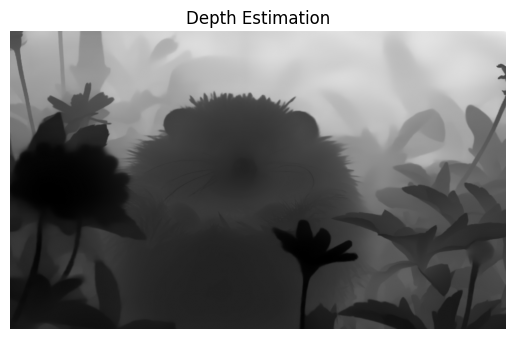

Field of View: 5.686939239501953
Focal Length: 10066.705078125


In [10]:
plt.imshow(apple_depthpro_depth.astype("uint8"), cmap='gray')
plt.title("Depth Estimation")
plt.axis('off')
plt.show()

print(f"Field of View: {field_of_view.item()}")
print(f"Focal Length: {focal_length.item()}")

Trying out a similar depth estimation model from Intel for comparison

In [11]:
processor = DPTImageProcessor.from_pretrained("Intel/dpt-large")
model = DPTForDepthEstimation.from_pretrained("Intel/dpt-large")

Some weights of DPTForDepthEstimation were not initialized from the model checkpoint at Intel/dpt-large and are newly initialized: ['neck.fusion_stage.layers.0.residual_layer1.convolution1.bias', 'neck.fusion_stage.layers.0.residual_layer1.convolution1.weight', 'neck.fusion_stage.layers.0.residual_layer1.convolution2.bias', 'neck.fusion_stage.layers.0.residual_layer1.convolution2.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [12]:
inputs = processor(images=img, return_tensors="pt")

with torch.no_grad():
    outputs = model(**inputs)
    predicted_depth = outputs.predicted_depth

# interpolate to original size
prediction = torch.nn.functional.interpolate(
    predicted_depth.unsqueeze(1),
    size=img.size[::-1],
    mode="bicubic",
    align_corners=False,
)

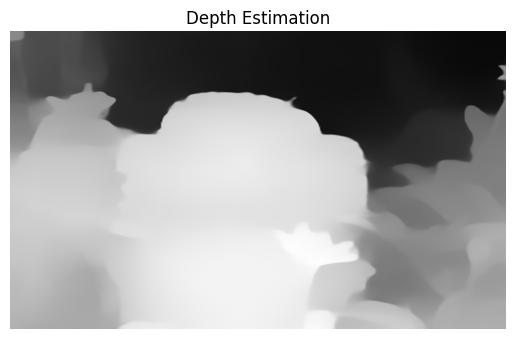

In [13]:
output = prediction.squeeze().cpu().numpy()
formatted = (output * 255 / np.max(output)).astype("uint8")
intel_dpt_depth = Image.fromarray(formatted)

plt.imshow(intel_dpt_depth, cmap='gray')
plt.title("Depth Estimation")
plt.axis('off')
plt.show()

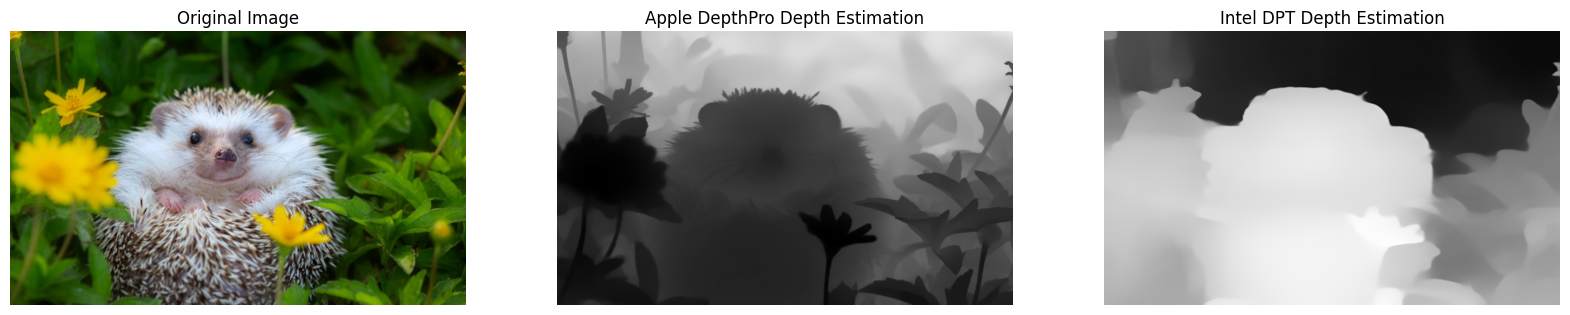

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(20, 5))

# Plot original image
axes[0].imshow(img)
axes[0].set_title("Original Image")
axes[0].axis('off')

# Plot Apple DepthPro depth
axes[1].imshow(apple_depthpro_depth.astype("uint8"), cmap='gray')
axes[1].set_title("Apple DepthPro Depth Estimation")
axes[1].axis('off')

# Plot Intel DPT depth
axes[2].imshow(intel_dpt_depth, cmap='gray')
axes[2].set_title("Intel DPT Depth Estimation")
axes[2].axis('off')

plt.show()

Big differences between both models, the Apple Depth Pro model does a better job as you can see the details of the image while the Intel model is less clear on the details.